In [1]:
# Cell 1: Install YOLO
!pip install -q ultralytics
print("✅ Installation complete.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.4 MB/s eta 0:00:00a 0:00:01
✅ Installation complete.


In [2]:
# Cell 2: Create Directories
import os
import shutil

print("🧹 Cleaning workspace for PRO run...")
work_dir = "/kaggle/working"

# Delete old folders to ensure a fresh start
if os.path.exists(f"{work_dir}/images"): shutil.rmtree(f"{work_dir}/images")
if os.path.exists(f"{work_dir}/labels"): shutil.rmtree(f"{work_dir}/labels")

# Create Train AND Val folders
os.makedirs(f"{work_dir}/images/train", exist_ok=True)
os.makedirs(f"{work_dir}/images/val", exist_ok=True)
os.makedirs(f"{work_dir}/labels/train", exist_ok=True)
os.makedirs(f"{work_dir}/labels/val", exist_ok=True)

print("✅ Folders ready: images/train, images/val")

🧹 Cleaning workspace for PRO run...
✅ Folders ready: images/train, images/val


In [3]:
# Cell 3: Find Data Source
import glob

print("🔍 Searching for dataset files...")
# Find the JSON label file
train_json = next(glob.iglob("/kaggle/input/**/*train*.json", recursive=True), None)

# Find the folder that contains images
image_dirs = glob.glob("/kaggle/input/**/train", recursive=True)
train_img_dir = next((d for d in image_dirs if len(glob.glob(f"{d}/*.jpg")) > 0), None)

# Fallback search
if not train_json or not train_img_dir:
    all_jpgs = glob.glob("/kaggle/input/**/*.jpg", recursive=True)
    if all_jpgs:
        train_img_dir = os.path.dirname(all_jpgs[0])

if not train_json or not train_img_dir:
    raise FileNotFoundError("❌ Dataset not found! Please check Kaggle Input.")
    
print(f"✅ Found Labels: {train_json}")
print(f"✅ Found Images: {train_img_dir}")

🔍 Searching for dataset files...
✅ Found Labels: /kaggle/input/solesensei_bdd100k/bdd100k_labels_release/bdd100k/labels/bdd100k_labels_images_train.json
✅ Found Images: /kaggle/input/solesensei_bdd100k/bdd100k_seg/bdd100k/seg/images/train


In [4]:
# Cell 4: Copy and Split Data
import json
import tqdm
import os
import shutil

# SETTINGS
LIMIT = 7000  # <--- Processing 7000 images
category_map = {'pedestrian': 0, 'rider': 1, 'car': 2, 'truck': 3, 'bus': 4, 'train': 5, 'motorcycle': 6, 'bicycle': 7, 'traffic light': 8, 'traffic sign': 9}

print(f"📦 Processing {LIMIT} images with 80/20 Split...")

with open(train_json) as f:
    data = json.load(f)

count = 0
for i, item in enumerate(tqdm.tqdm(data)):
    if count >= LIMIT: break
    
    name = item['name']
    src_path = os.path.join(train_img_dir, name)
    
    if not os.path.exists(src_path): continue
    
    # Label Conversion
    labels = item.get('labels') or []
    lines = []
    for label in labels:
        if label['category'] in category_map and 'box2d' in label:
            cls = category_map[label['category']]
            b = label['box2d']
            w = (b['x2'] - b['x1']) / 1280
            h = (b['y2'] - b['y1']) / 720
            xc = (b['x1'] + b['x2']) / 2 / 1280
            yc = (b['y1'] + b['y2']) / 2 / 720
            lines.append(f"{cls} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}")
    
    if lines:
        # 80% Train, 20% Val Split
        if i % 5 == 0: 
            folder = "val"
        else:
            folder = "train"
            
        # Write Label
        with open(f"{work_dir}/labels/{folder}/{name.replace('.jpg','.txt')}", 'w') as f:
            f.write('\n'.join(lines))
        
        # Copy Image
        shutil.copy(src_path, f"{work_dir}/images/{folder}/{name}")
        count += 1

print(f"✅ Successfully prepared {count} images.")

📦 Processing 7000 images with 80/20 Split...


100%|██████████| 69863/69863 [01:04<00:00, 1075.76it/s]

✅ Successfully prepared 2972 images.


In [5]:
# Cell 5: Create YAML Config
yaml_content = f"""
path: {work_dir}
train: images/train
val: images/val   # Now pointing to the real validation folder
names:
  0: pedestrian
  1: rider
  2: car
  3: truck
  4: bus
  5: train
  6: motorcycle
  7: bicycle
  8: traffic light
  9: traffic sign
"""
with open("bdd_pro.yaml", "w") as f: f.write(yaml_content)
print("✅ Config 'bdd_pro.yaml' created.")

✅ Config 'bdd_pro.yaml' created.


In [6]:
# Cell 6: Run Training
from ultralytics import YOLO

print("🚀 Starting PRO Training...")
print("NOTE: This will take 3-4 hours. Keep this tab open!")

# Load the Medium model
model = YOLO('yolo11m.pt') 

results = model.train(
    data='bdd_pro.yaml',
    epochs=50,
    imgsz=640,
    batch=8,         # Set to 8 for safety with Medium model
    project='/kaggle/working/runs',
    name='bdd_pro_run',
    plots=True,
    val=True,        # Validation enabled!
    amp=False,
    workers=0,
    exist_ok=True
)

print("✅ Training Complete.")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
🚀 Starting PRO Training...
NOTE: This will take 3-4 hours. Keep this tab open!
Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=bdd_pro.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015,

👀 Testing PRO model on 598 unseen images...

image 1/1 /kaggle/working/images/val/83f6c772-8698c5d5.jpg: 384x640 14 cars, 1 traffic light, 50.6ms
Speed: 4.0ms preprocess, 50.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


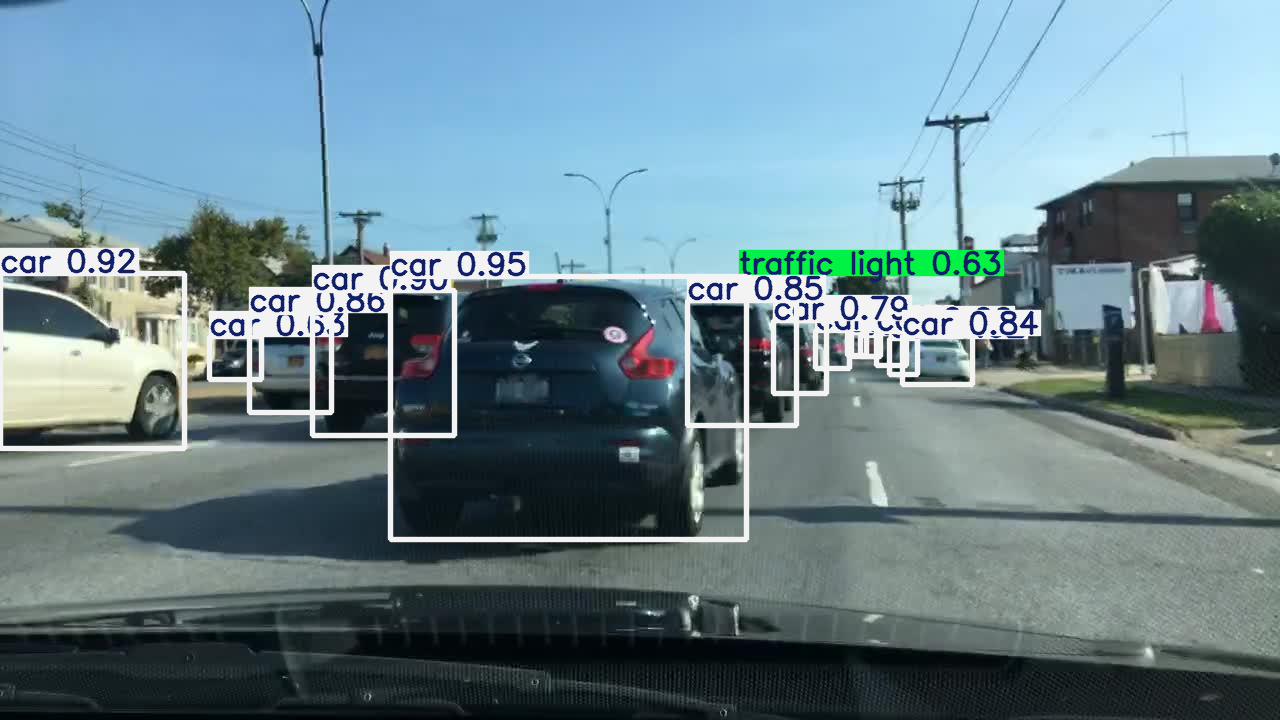


image 1/1 /kaggle/working/images/val/631973a4-ed1655d9.jpg: 384x640 15 cars, 1 traffic sign, 24.0ms
Speed: 1.7ms preprocess, 24.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


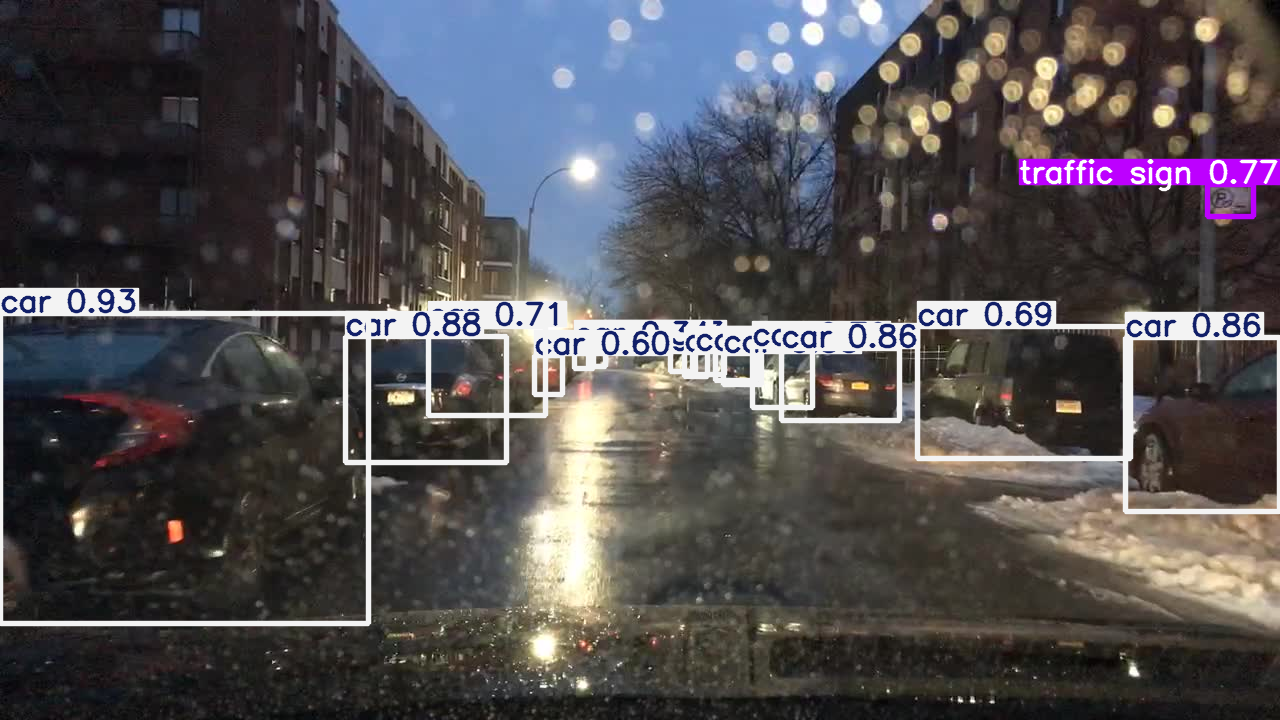


image 1/1 /kaggle/working/images/val/0a0a0b1a-7c39d841.jpg: 384x640 4 cars, 1 truck, 24.0ms
Speed: 1.7ms preprocess, 24.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


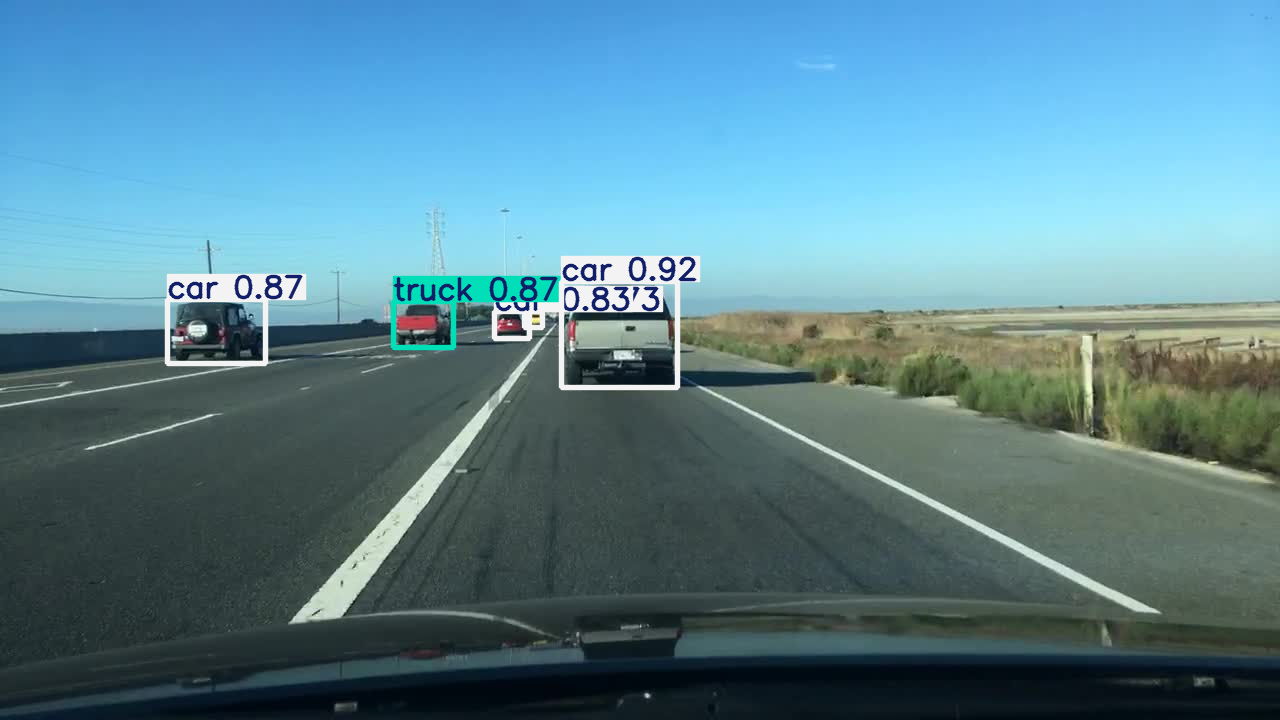

In [7]:
# Cell 7: Visual Validation of PRO Model
from ultralytics import YOLO
import glob
import random
from PIL import Image
from IPython.display import display

# Load your new PRO model
model = YOLO('/kaggle/working/runs/bdd_pro_run/weights/best.pt')

# Pick random images from the Validation set (Unseen images)
val_images = glob.glob('/kaggle/working/images/val/*.jpg')

print(f"👀 Testing PRO model on {len(val_images)} unseen images...")

# Show 3 examples
for i in range(3):
    if not val_images: break
    test_image = random.choice(val_images)
    
    # Run prediction
    results = model(test_image)
    
    # Display
    for r in results:
        im_array = r.plot()  # Draw boxes
        im = Image.fromarray(im_array[..., ::-1])
        display(im)

📊 PRO Training Loss Curves (50 Epochs):


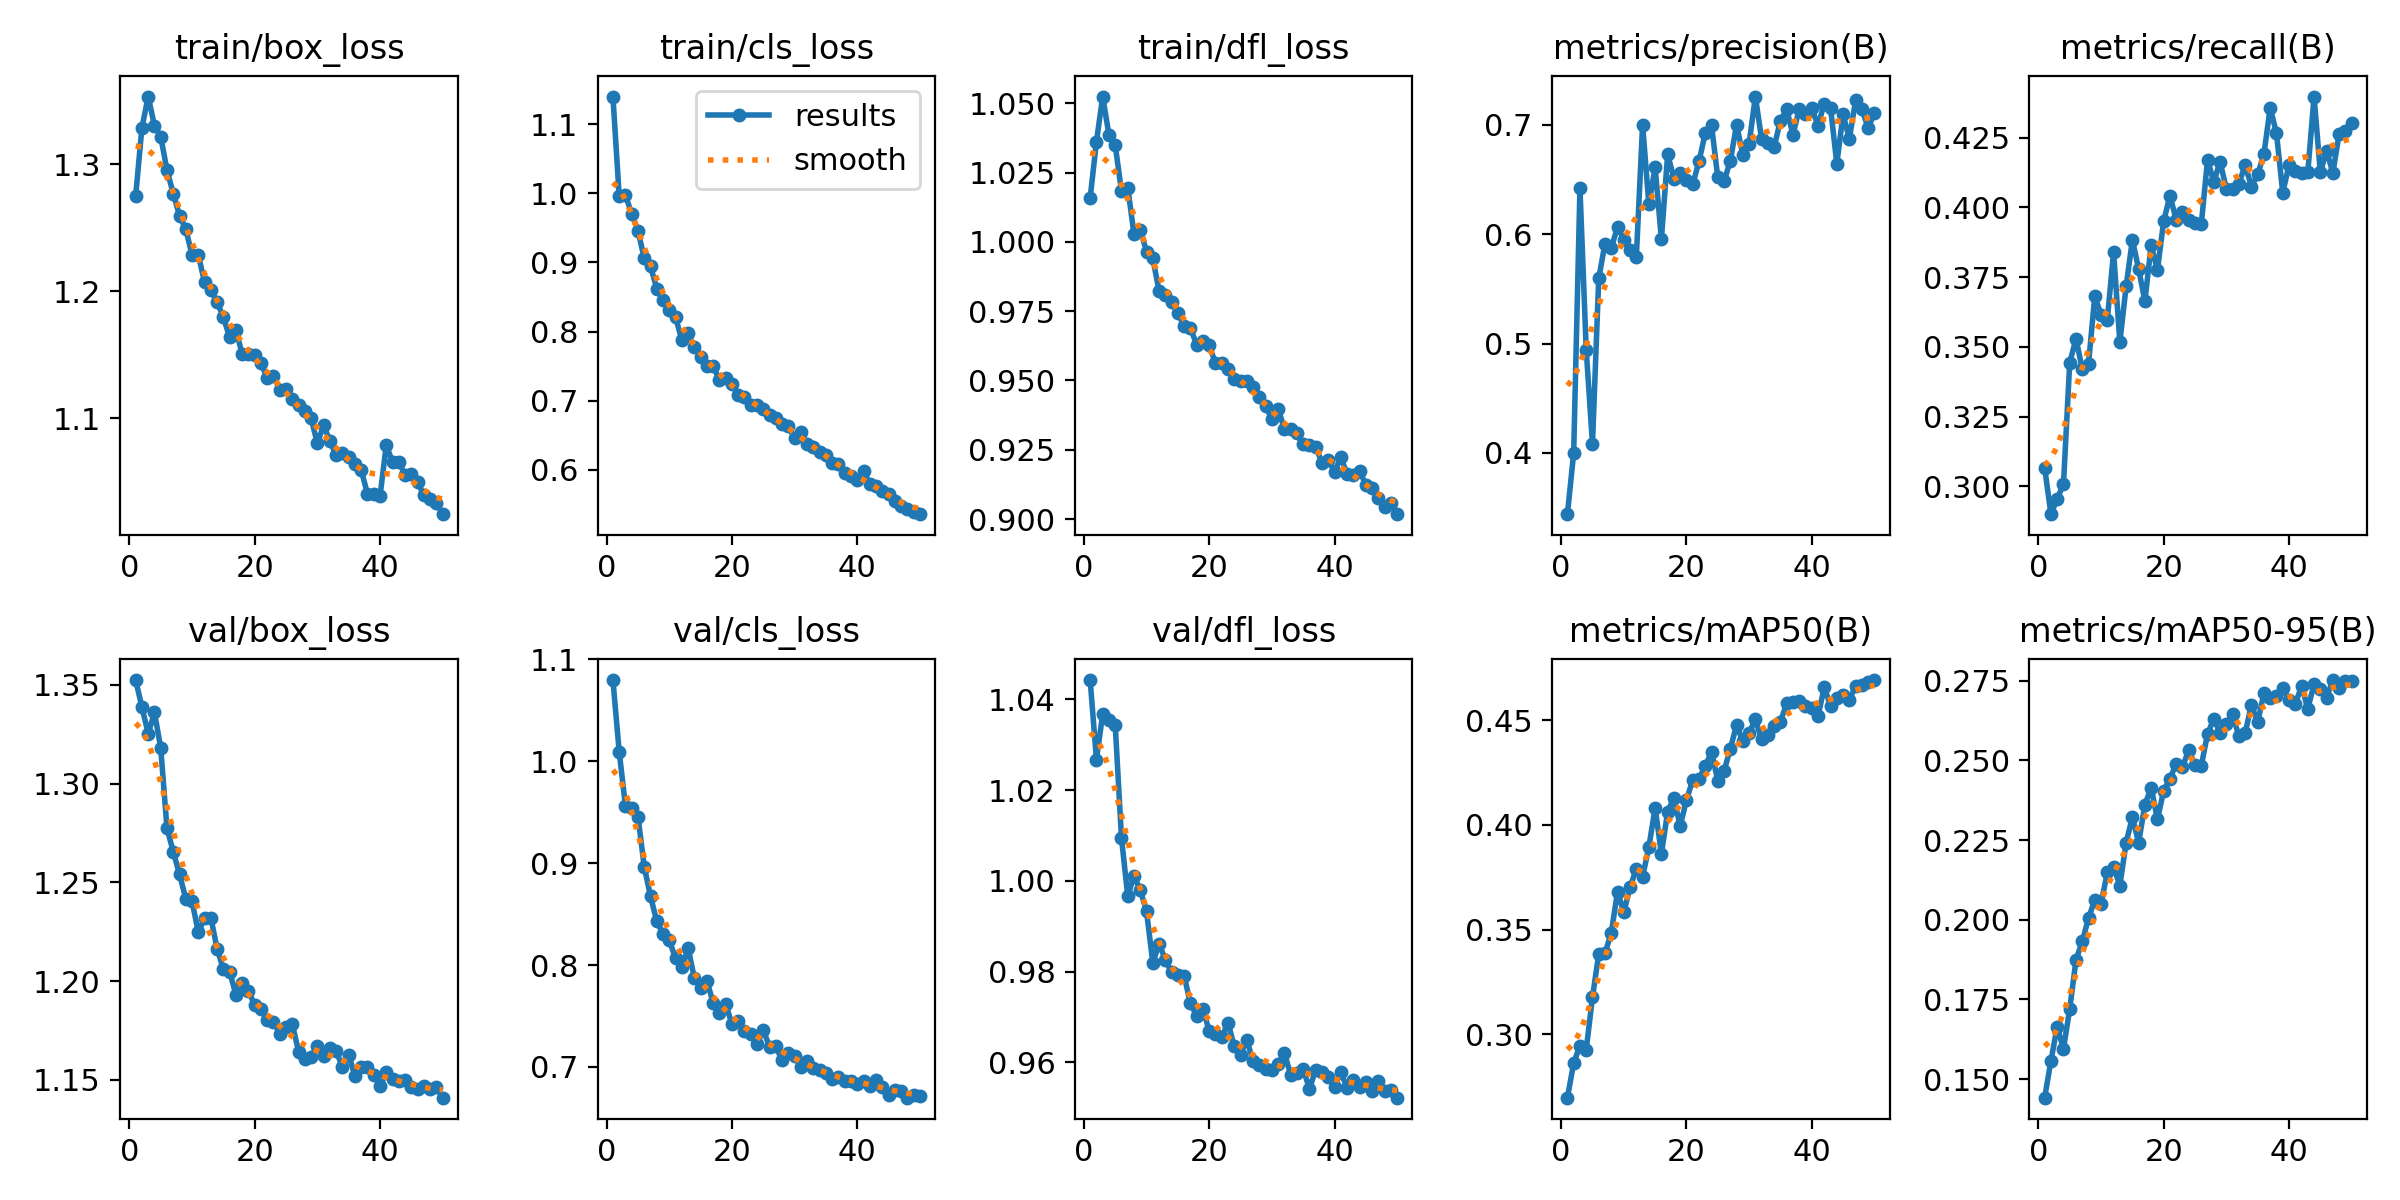


🧩 PRO Confusion Matrix (Validation Data):


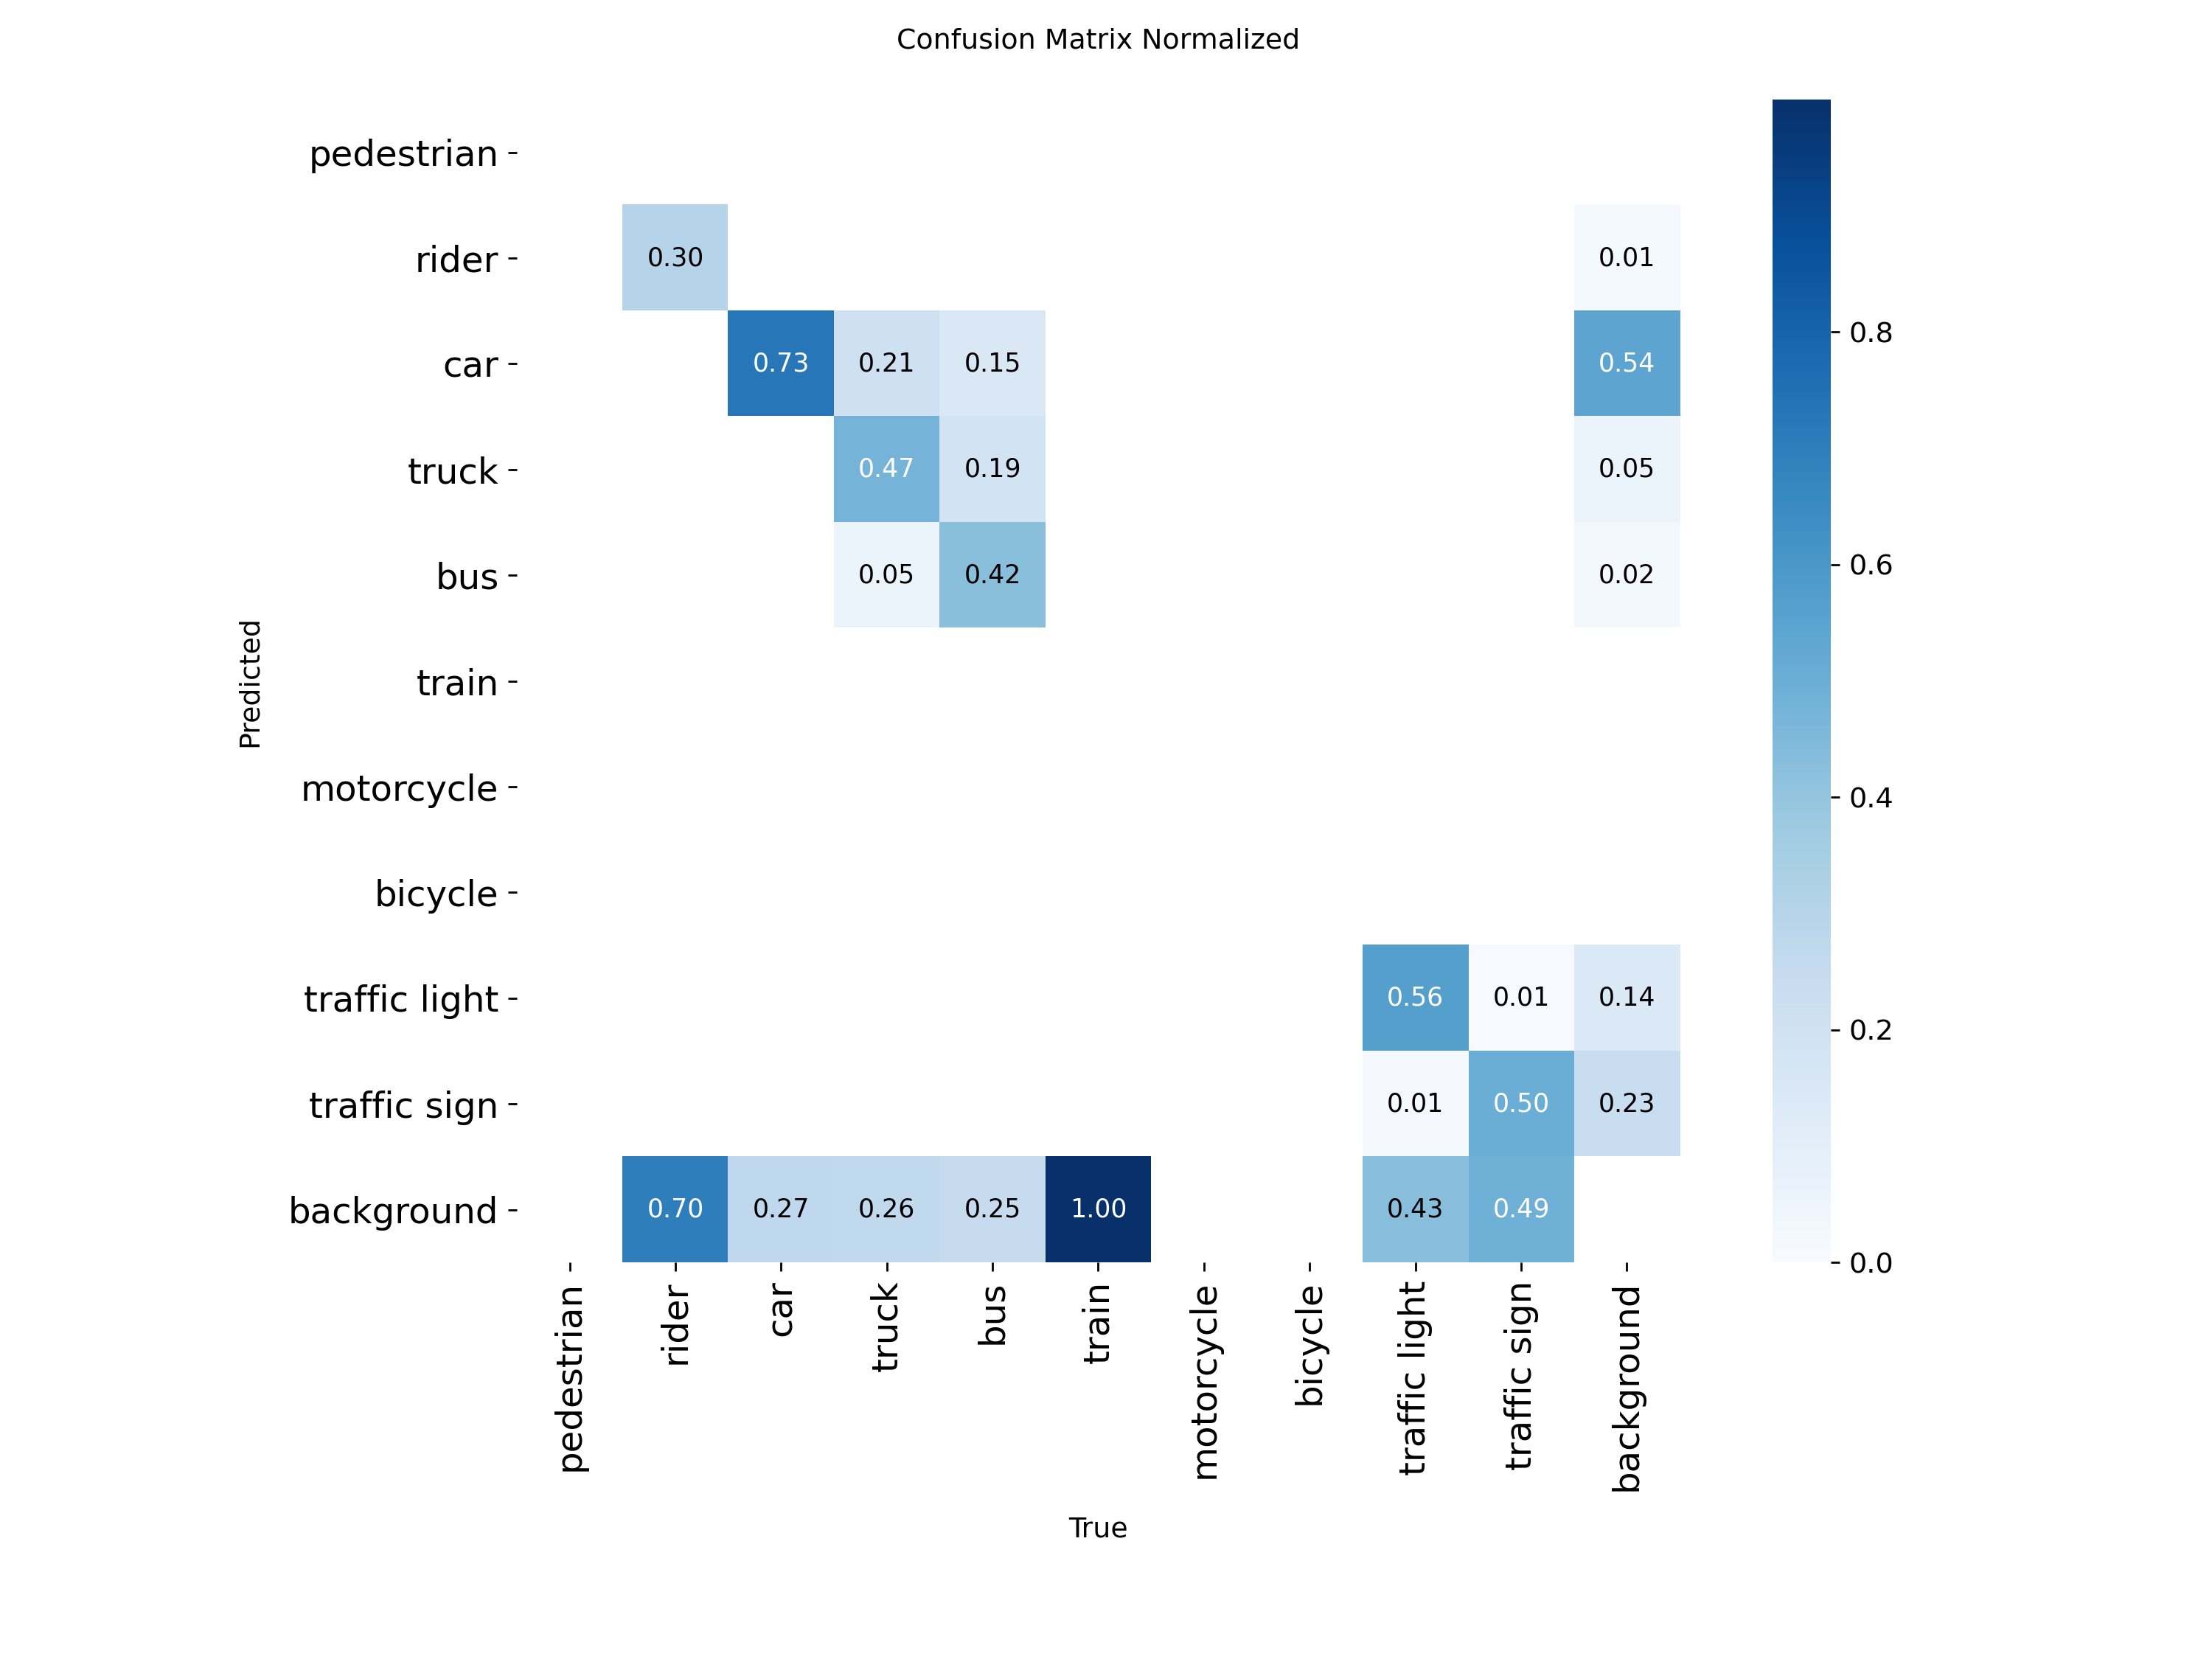

In [8]:
# Cell 8: Display Pro Report Graphs
from IPython.display import Image, display
import os

# Path to the PRO run folder
run_folder = '/kaggle/working/runs/bdd_pro_run'

print("📊 PRO Training Loss Curves (50 Epochs):")
# This shows the long-term learning process
if os.path.exists(f'{run_folder}/results.png'):
    display(Image(filename=f'{run_folder}/results.png'))
else:
    print("❌ Results.png not found. Did the training finish?")

print("\n🧩 PRO Confusion Matrix (Validation Data):")
# This shows the accuracy on UNSEEN data (Validation set)
if os.path.exists(f'{run_folder}/confusion_matrix_normalized.png'):
    # We prefer the 'normalized' one if it exists, it shows percentages
    display(Image(filename=f'{run_folder}/confusion_matrix_normalized.png'))
elif os.path.exists(f'{run_folder}/confusion_matrix.png'):
    display(Image(filename=f'{run_folder}/confusion_matrix.png'))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 30.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 7.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
🔪 Slicing and detecting on: /kaggle/working/images/val/9427e01b-d903c8d7.jpg
Performing prediction on 6 slices.


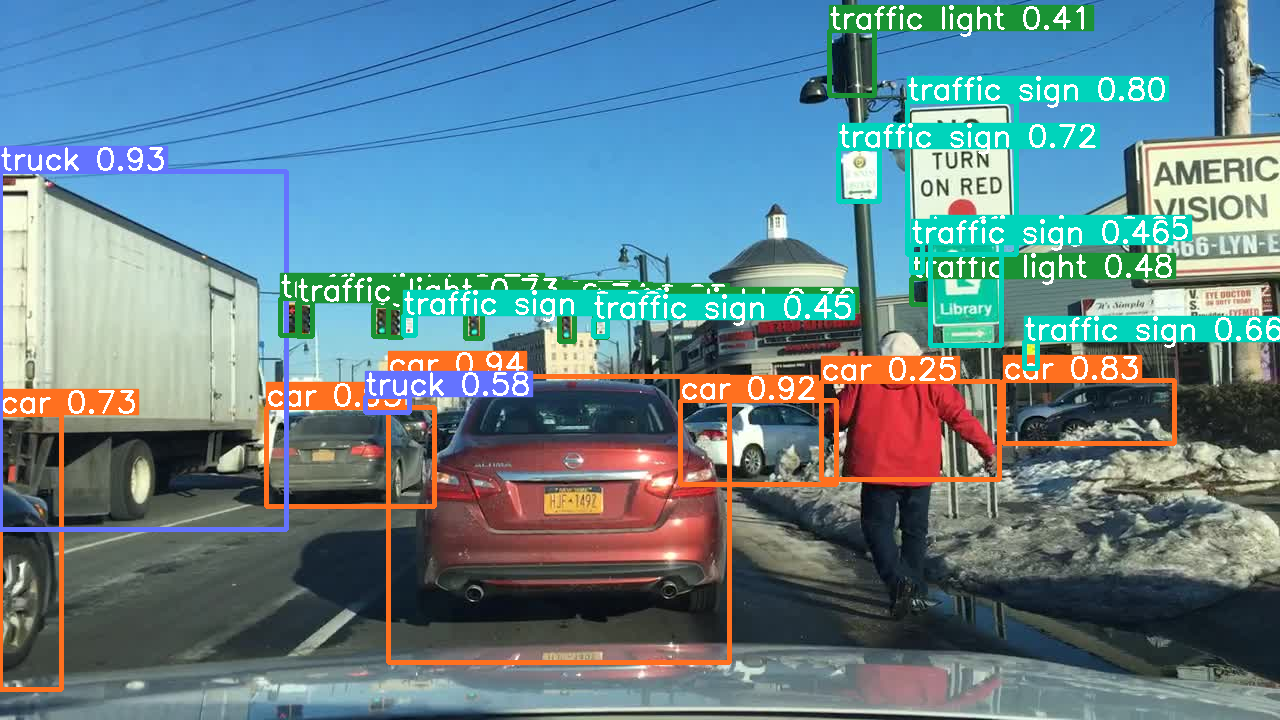

In [9]:
# 1. Install the library (Takes 10 seconds)
!pip install -q sahi

# 2. Set up the "Slicer" with your EXISTING model
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction
from IPython.display import Image, display
import glob
import random

# Load the model you ALREADY trained
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8',  # This wrapper works for YOLO11 too
    model_path='/kaggle/working/runs/bdd_pro_run/weights/best.pt', # <--- Your 4-hour model
    confidence_threshold=0.25,
    device="cuda:0"
)

# 3. Pick a random Validation Image to test
val_images = glob.glob('/kaggle/working/images/val/*.jpg')
test_image = random.choice(val_images)

print(f"🔪 Slicing and detecting on: {test_image}")

# 4. Run the Sliced Prediction (Takes ~1-2 seconds per image)
result = get_sliced_prediction(
    test_image,
    detection_model,
    slice_height=512,  # Zoom in to 512x512 tiles
    slice_width=512,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2
)

# 5. Show the result
result.export_visuals(export_dir=".", file_name="sahi_result")
display(Image("sahi_result.png"))

✅ Found valid image: /kaggle/working/images/val/4a8785c2-9440b53f.jpg
Running Standard YOLO...

image 1/1 /kaggle/working/images/val/4a8785c2-9440b53f.jpg: 384x640 15 cars, 1 truck, 1 traffic light, 24.7ms
Speed: 2.0ms preprocess, 24.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
Running SAHI (Slicing)...
Performing prediction on 6 slices.


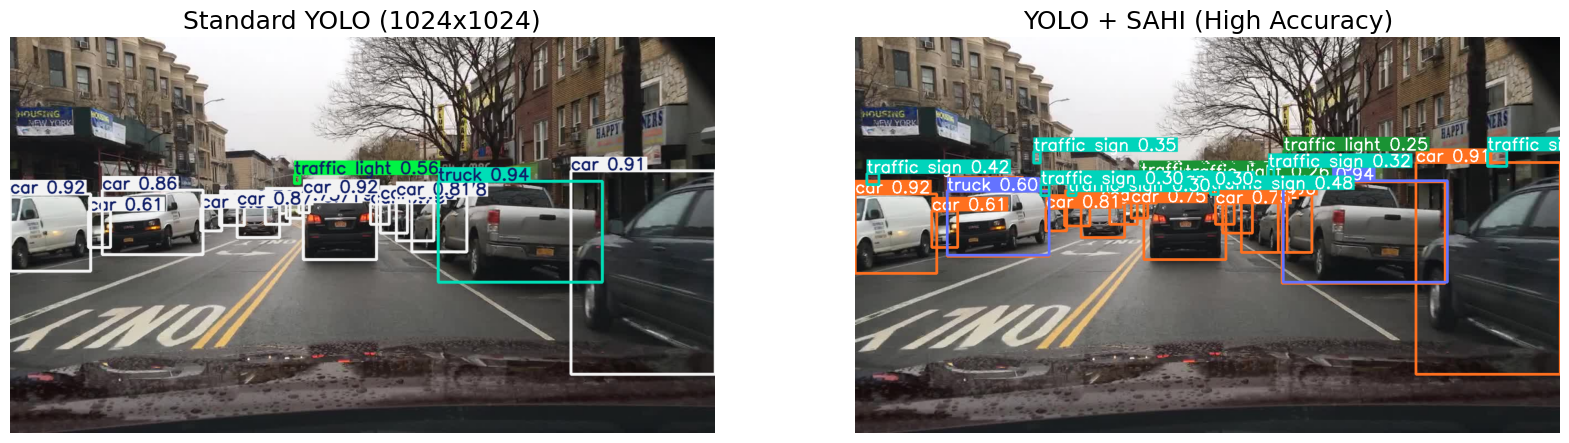

In [17]:
import glob
import random
import cv2
import matplotlib.pyplot as plt
from sahi.predict import get_sliced_prediction
from sahi import AutoDetectionModel
from ultralytics import YOLO

real_images = glob.glob("/kaggle/working/images/val/*.jpg")

if not real_images:
    print("❌ Error: No images found in /kaggle/working/images/val/")
    print("Please check if your dataset is unzipped correctly.")
else:
    # Pick a random one to test
    image_path = random.choice(real_images)
    print(f"✅ Found valid image: {image_path}")

    # 2. Run OLD Way (Standard YOLO)
    print("Running Standard YOLO...")
    model = YOLO('/kaggle/working/runs/bdd_pro_run/weights/best.pt')
    results_standard = model(image_path)
    res_plotted = results_standard[0].plot() 

    # 3. Run NEW Way (SAHI)
    print("Running SAHI (Slicing)...")
    detection_model = AutoDetectionModel.from_pretrained(
        model_type='yolov8',
        model_path='/kaggle/working/runs/bdd_pro_run/weights/best.pt',
        confidence_threshold=0.25,
        device="cuda:0"
    )
    
    result_sahi = get_sliced_prediction(
        image_path,
        detection_model,
        slice_height=512,
        slice_width=512
    )
    
    # Export SAHI result
    result_sahi.export_visuals(export_dir=".", file_name="sahi_temp")
    sahi_image = cv2.imread("sahi_temp.png")

    # 4. Show Side-by-Side Comparison
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    # Left: Standard
    ax[0].imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
    ax[0].set_title("Standard YOLO (1024x1024)", fontsize=18)
    ax[0].axis('off')

    # Right: SAHI
    ax[1].imshow(cv2.cvtColor(sahi_image, cv2.COLOR_BGR2RGB))
    ax[1].set_title("YOLO + SAHI (High Accuracy)", fontsize=18)
    ax[1].axis('off')

    plt.show()